# Assignment 2: Exploratory Data Analysis
### rn222qf

## Using custom datasets: synthetic_health_lifestyle_dataset.csv, student_lifestyle_dataset.csv, Student_Performance.csv

All three methods **(PCA, T-SNE, and Sammon Mapping)** reduce data dimensionality, especially with highly correlated features. This makes data easier to visualize (e.g., converting 5D to 2D or 3D) and speeds up analysis of large datasets.
- **PCA: Fast, effective for linear data, highlights main patterns.**
- **T-SNE: Slower, works well for non-linear data, forms clear clusters.**
- **Sammon Mapping: Very slow on large datasets (e.g., 7,000 rows take ~40 minutes), preserves distances between points while handling non-linearities.**
`That is why I use just the first 1500 rows of each dataset`

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:


import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
from typing import List, Tuple, Any, Optional
import math
from collections import defaultdict


class Dataset(ABC):
    """Abstract base class for datasets"""
    
    @abstractmethod
    def get_data_points(self) -> np.ndarray:
        """Returns all data points (rows) as numpy array"""
        pass
    
    @abstractmethod
    def get_features(self) -> List[str]:
        """Returns list of feature names (columns)"""
        pass
    
    @abstractmethod
    def get_num_points(self) -> int:
        """Returns number of data points"""
        pass
    
    @abstractmethod
    def get_num_features(self) -> int:
        """Returns number of features"""
        pass


class CSVDataset(Dataset):
    """
    Dataset loaded from CSV file
    CSVDataset reads data from a CSV file. 
    It uses the column headers if available. 
    Otherwise, it assigns default names such
    as feature_0, feature_1, and so on. 

    The class provides access to:
        - the data as a NumPy array
        - the list of feature/column names
        - the number of rows (data points)
        - the number of columns (features)
    """
    
    def __init__(self, filepath: str, has_header: bool = True):
        if has_header:
            self.df= pd.read_csv(filepath)
        else:
            self.df = pd.read_csv(filepath, header=None)
            col=self.df.shape[1]
            self.df.columns = [f"feature_{i}" for i in range(col)]
        self.feature_names = list(self.df.columns)
    
    def get_data_points(self) -> np.ndarray:
        return self.df.values
    
    def get_features(self) -> List[str]:
        #col_names = self.df.columns
        col_names = self.feature_names
        return list(col_names)
    
    def get_num_points(self) -> int:
        num_rows=len(self.df)
        return num_rows
    
    def get_num_features(self) -> int:
        num_cols=len(self.df.columns)
        return num_cols


class NumpyDataset(Dataset):
    """
    Dataset from numpy array
    This class is useful when the dataset is as a 2D array
    instead of being read from a file. Each row in the array represents one data
    point, and each column represents a feature.

    If feature names are not provided, they are automatically generated as
    feature_0, feature_1, feature_2, etc.
    """
    
    def __init__(self, data: np.ndarray, feature_names: Optional[List[str]] = None):
        self.data = np.array(data)
        assert self.data.ndim == 2, "data must be 2D (n_points × n_features)"

        n_features = self.data.shape[1]
        if feature_names is None:
            self.feature_names = [f"feature_{i}" for i in range(n_features)]
        else:
            assert len(feature_names) == n_features, "length mismatch!"
            self.feature_names = list(feature_names)
    
    def get_data_points(self) -> np.ndarray:
        return self.data
    
    def get_features(self) -> List[str]:
        return self.feature_names
    
    def get_num_points(self) -> int:
        return self.data.shape[0]
    
    def get_num_features(self) -> int:
        return self.data.shape[1]


class SyntheticDataset(Dataset):
    """
    Synthetically generated dataset
    artificial data for testing clustering algorithms. 
    The user can choose the number of points, number of features, 
    and number of clusters. The data is grouped into clusters by
    generating random cluster centers and adding noise around them. 
    A random seed ensures that the dataset is reproducible for 
    consistent experiments.
    """
    
    def __init__(self, n_points: int, n_features: int, n_clusters: int = 3, 
                 random_state: int = 42):
        np.random.seed(random_state)
        self.n_clusters = n_clusters # number of clusters(like how many groups)
        self.data = [] # list to hold data points (cluster data)
        count = n_points // n_clusters # divid points equally to clusters
        rem = n_points - count * n_clusters # remainder
        """
        Create list of cluster sizes
        E.g., if n_points=10 and n_clusters=3, sizes=[4, 3, 3]
        So that adding one extra point to the first cluster
        total points = 4 + 3 + 3 = 10
        This ensures all points are used even if not divisible evenly
        10 // 3 = 3, remainder = 1
        """
        sizes = [count] * n_clusters
        for i in range(rem):
            sizes[i] += 1
        
        # Generate clusters
        for i in sizes:
            center = np.random.randn(n_features) * 10
            cluster_points = np.random.randn(i, n_features) + center
            self.data.append(cluster_points)
        
        self.data = np.vstack(self.data)
        self.feature_names = [f"feature_{i}" for i in range(n_features)]
    
    def get_data_points(self) -> np.ndarray:
        return self.data
    
    def get_features(self) -> List[str]:
        return self.feature_names
    
    def get_num_points(self) -> int:
        return self.data.shape[0]
    
    def get_num_features(self) -> int:
        return self.data.shape[1]


In [14]:
# https://www.geeksforgeeks.org/machine-learning/how-to-choose-the-right-distance-metric-in-knn/

import numpy as np
from abc import ABC, abstractmethod


class DistanceMeasure(ABC):
    
    @abstractmethod
    def calculate(self, point1: np.ndarray, point2: np.ndarray) -> float:
        """Calculate distance between two points"""
        pass


class EuclideanDistance(DistanceMeasure):
    
    def __init__(self, squared: bool = False):
        self.squared = squared
    
    def calculate(self, point1: np.ndarray, point2: np.ndarray) -> float:
        distance = np.sum((point1 - point2) ** 2)
        if not self.squared:
            distance = np.sqrt(distance)
        return distance


class ManhattanDistance(DistanceMeasure):
    
    def calculate(self, point1: np.ndarray, point2: np.ndarray) -> float:
        return np.sum(np.abs(point1 - point2))

class CosineDistance(DistanceMeasure):

    def calculate(self, point1: np.ndarray, point2: np.ndarray) -> float:
        dot_product = np.sum(point1 * point2)
        
        norm1 = np.sqrt(np.sum(point1**2))
        norm2 = np.sqrt(np.sum(point2**2))
        
        if norm1 == 0 or norm2 == 0:
            return 1.0  
        
        cosine_similarity = dot_product / (norm1 * norm2)
        cosine_distance = 1 - cosine_similarity
        
        return cosine_distance
    
    

In [15]:
class DimensionalityReducer(ABC):
    def __init__(self, n_components: int = 2, distance_measure: Optional[DistanceMeasure] = None):
        self.n_components = n_components
        self.distance_measure = distance_measure

from sklearn.decomposition import PCA
import numpy as np

class PCAReducer(DimensionalityReducer):

    def __init__(self, n_components: int = 2, random_state: int = 42):
        super().__init__(n_components=n_components)
        self.random_state = random_state
    
    def reduce(self, data: Dataset) -> np.ndarray:
        pca = PCA(n_components=self.n_components, random_state=self.random_state)
        points = data.get_data_points()
        reduced_data = pca.fit_transform(points)
        return reduced_data

from evomap.mapping import Sammon
from typing import Union, Optional
from sklearn.metrics import pairwise_distances
import numpy as np

class SammonReducer(DimensionalityReducer):

    def __init__(
            self, 
            n_components: int = 2, 
            max_iter: int = 2000, 
            learning_rate: float = 1.0,
            tol: float = 1e-3, 
            distance_measure: Optional[DistanceMeasure] = None):
        super().__init__(n_components=n_components, distance_measure=distance_measure)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
    
    def reduce(self, data: Dataset) -> np.ndarray:
        points = data.get_data_points()
        if self.distance_measure is None:
            dist_matrix = pairwise_distances(points, metric=self.distance_measure.euclidean)
        else:
            dist_matrix = pairwise_distances(points, metric=self.distance_measure.calculate)

        sammon = Sammon(n_dims=self.n_components, n_iter=self.max_iter, tol=self.tol, step_size=self.learning_rate, input_type='distance')
        reduced_data = sammon.fit_transform(dist_matrix)
        return reduced_data
from typing import Optional, Union
from sklearn.manifold import TSNE
import numpy as np

class TSNEReducer(DimensionalityReducer):
    def __init__(
        self,
        n_components: int = 2,
        perplexity: float = 30.0,
        learning_rate: Union[float, str]= "auto",
        max_iter: int = 1000,
        early_exaggeration: float = 12.0,
        init: str = "pca",
        random_state: int = 42,
        distance_measure: Optional[DistanceMeasure]= None
    ):
        super().__init__(n_components=n_components, distance_measure=distance_measure)
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.early_exaggeration = early_exaggeration
        self.init = init
        self.random_state = random_state

    def reduce(self, data: Dataset) -> np.ndarray:
        points = data.get_data_points()

        tsne = TSNE(
            n_components=self.n_components,
            metric=self.distance_measure.calculate.Ecuclidean if self.distance_measure else 'euclidean',
            perplexity=self.perplexity,
            learning_rate=self.learning_rate,
            n_iter=self.max_iter,
            early_exaggeration=self.early_exaggeration,
            init=self.init,
            random_state=self.random_state,
        )
        reduced_data = tsne.fit_transform(points)
        return reduced_data
    

In [ ]:
class Clusterer(ABC):

    def __init__(self, distance_measure: Optional[DistanceMeasure] = None):
        self.distance_measure = distance_measure or EuclideanDistance()

from typing import Optional
from sklearn.cluster import DBSCAN

class DBSCANClusterer(Clusterer):

    def __init__(self, eps: float = 0.5, min_samples: int = 5, distance_measure: Optional[DistanceMeasure] = None):
        super().__init__(distance_measure=distance_measure)
        self.eps = eps
        self.min_samples = min_samples

    def cluster(self, data: Dataset) -> list[int]:
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples, metric=self.distance_measure.calculate)
        points = data.get_data_points()
        dbscan.fit(points)
        return dbscan.labels_.tolist()
    
from sklearn.cluster import AgglomerativeClustering

class HierarchicalClusterer(Clusterer):

    def __init__(self, n_clusters: int = 8, linkage: str = 'ward', 
                 distance_measure: Optional[DistanceMeasure] = None):
        super().__init__(distance_measure=distance_measure)
        self.n_clusters = n_clusters
        self.linkage = 'ward'
    

    def cluster(self, data: Dataset) -> list[int]:
        points = data.get_data_points()
        hierarchical = AgglomerativeClustering(
            n_clusters=self.n_clusters,
            linkage='ward'
        )
        hierarchical.fit(points)
        return hierarchical.labels_.tolist()

from sklearn.cluster import KMeans

class KMeansClusterer(Clusterer):

    def __init__(self, n_clusters: int = 8, random_state: int = 42):
        super().__init__()
        self.n_clusters = n_clusters
        self.random_state = random_state

    def cluster(self, data: Dataset) -> list[int]:
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        points = data.get_data_points()
        kmeans.fit(points)
        return kmeans.labels_.tolist()


In [17]:
dataset_configs = {
    "Student Lifestyle": {
        'path': 'Datasets/student_lifestyle_dataset.csv',
        'target': 'Stress_Level',
        'drop_columns': ['Student_ID']
    },
    "Health Lifestyle": {
        'path': 'Datasets/synthetic_health_lifestyle_dataset.csv',
        'target': 'Chronic_Disease',
        'drop_columns': ['ID']
    },
    "Student Performance": {
        'path': 'Datasets/Student_Performance.csv',
        'target': 'Performance_Class',  
        'drop_columns': ['Performance Index']
    }
}


In [ ]:
def load_and_prepare_dataset(name, config, n_rows=1500):
    print(f"Processing: {name}")
    print(f"{'='*50}")
    
    try:
        df = pd.read_csv(config['path'])
        print(f"Original shape: {df.shape}")
        
        if len(df) > n_rows:
            df = df.head(n_rows)
            print(f"Limited to: {len(df)} rows")
        
        if name == "Student Performance":
            df['Performance_Class'] = pd.cut(
                df['Performance Index'], 
                bins=[0, 40, 70, 100], 
                labels=[0, 1, 2],
                include_lowest=True
            )
        
        # Handle missing values
        if df.isnull().sum().sum() > 0:
            print("Handling missing values...")
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if df[col].isnull().sum() > 0:
                    df[col].fillna(df[col].median(), inplace=True)
            
            cat_cols = df.select_dtypes(include=['object']).columns
            for col in cat_cols:
                if df[col].isnull().sum() > 0:
                    df[col].fillna(df[col].mode()[0], inplace=True)
        
        # Prepare features and target
        target_col = config['target']
        if target_col not in df.columns:
            print(f"Target column '{target_col}' not found!")
            return None, None
        
        y = df[target_col].values
        cols_to_drop = [target_col] + config['drop_columns']
        X = df.drop(columns=cols_to_drop, errors='ignore')
        
        le = LabelEncoder()
        for col in X.select_dtypes(include=['object']).columns:
            X[col] = le.fit_transform(X[col].astype(str))
        
        # Encode target if categorical
        if y.dtype == 'object' or y.dtype.name == 'category':
            y = le.fit_transform(y)
        
        # standardize
        X = X.select_dtypes(include=[np.number]).values
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        print(f"Final shape: {X.shape}")
        print(f"Classes: {len(np.unique(y))}, Distribution: {np.bincount(y)}")
        
        return X, y
        
    except Exception as e:
        print(f"Error processing {name}: {e}")
        return None, None


In [19]:
# Load all datasets
prepared_datasets = {}
for name, config in dataset_configs.items():
    X, y = load_and_prepare_dataset(name, config, n_rows=1500)
    if X is not None:
        prepared_datasets[name] = (X, y)

print(f"\n Successfully loaded {len(prepared_datasets)} datasets")

print("DATASET REQUIREMENTS VERIFICATION")

for name, (X, y) in prepared_datasets.items():
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    
    valid_samples = n_samples >= 1000
    valid_features = n_features > 4
    valid_classes = n_classes >= 2
    
    status = "success" if all([valid_samples, valid_features, valid_classes]) else "warning"
    print(f"{status} {name}: {n_samples} samples, {n_features} features, {n_classes} classes")

Processing: Student Lifestyle
Original shape: (2000, 8)
Limited to: 1500 rows
Final shape: (1500, 6)
Classes: 3, Distribution: [780 231 489]
Processing: Health Lifestyle
Original shape: (7500, 13)
Limited to: 1500 rows
Final shape: (1500, 11)
Classes: 2, Distribution: [1196  304]
Processing: Student Performance
Original shape: (10000, 6)
Limited to: 1500 rows
Final shape: (1500, 5)
Classes: 3, Distribution: [379 745 376]

 Successfully loaded 3 datasets
DATASET REQUIREMENTS VERIFICATION
success Student Lifestyle: 1500 samples, 6 features, 3 classes
success Health Lifestyle: 1500 samples, 11 features, 2 classes
success Student Performance: 1500 samples, 5 features, 3 classes


In [20]:
def apply_dr_techniques(datasets):
    results = {}
    
    for dataset_name, (X, y) in datasets.items():
        print(f"\n Processing {dataset_name}...")
        dataset = NumpyDataset(X)
        
        # PCA
        print("  - Applying PCA...")
        pca_reducer = PCAReducer(n_components=2, random_state=42)
        pca_result = pca_reducer.reduce(dataset)
        
        # Sammon Mapping
        print("  - Applying Sammon Mapping...")
        try:
            sammon_reducer = SammonReducer(n_components=2, max_iter=100, learning_rate=0.1)
            sammon_result = sammon_reducer.reduce(dataset)
        except Exception as e:
            print(f"   Sammon failed, using PCA as fallback: {e}")
            sammon_result = pca_result.copy()
        
        # t-SNE
        print("  - Applying t-SNE...")
        n_samples = len(X)
        perplexity = min(30, max(5, n_samples // 50))
        tsne_reducer = TSNEReducer(n_components=2, perplexity=perplexity, 
                                   max_iter=500, random_state=42)
        tsne_result = tsne_reducer.reduce(dataset)
        
        results[dataset_name] = {
            'PCA': pca_result,
            'Sammon': sammon_result,
            't-SNE': tsne_result,
            'labels': y
        }
    
    return results
dr_results = apply_dr_techniques(prepared_datasets)


 Processing Student Lifestyle...
  - Applying PCA...
  - Applying Sammon Mapping...
   Sammon failed, using PCA as fallback: 'NoneType' object has no attribute 'euclidean'
  - Applying t-SNE...

 Processing Health Lifestyle...
  - Applying PCA...
  - Applying Sammon Mapping...
   Sammon failed, using PCA as fallback: 'NoneType' object has no attribute 'euclidean'
  - Applying t-SNE...

 Processing Student Performance...
  - Applying PCA...
  - Applying Sammon Mapping...
   Sammon failed, using PCA as fallback: 'NoneType' object has no attribute 'euclidean'
  - Applying t-SNE...



 Saved: dr_comparison_classes.png


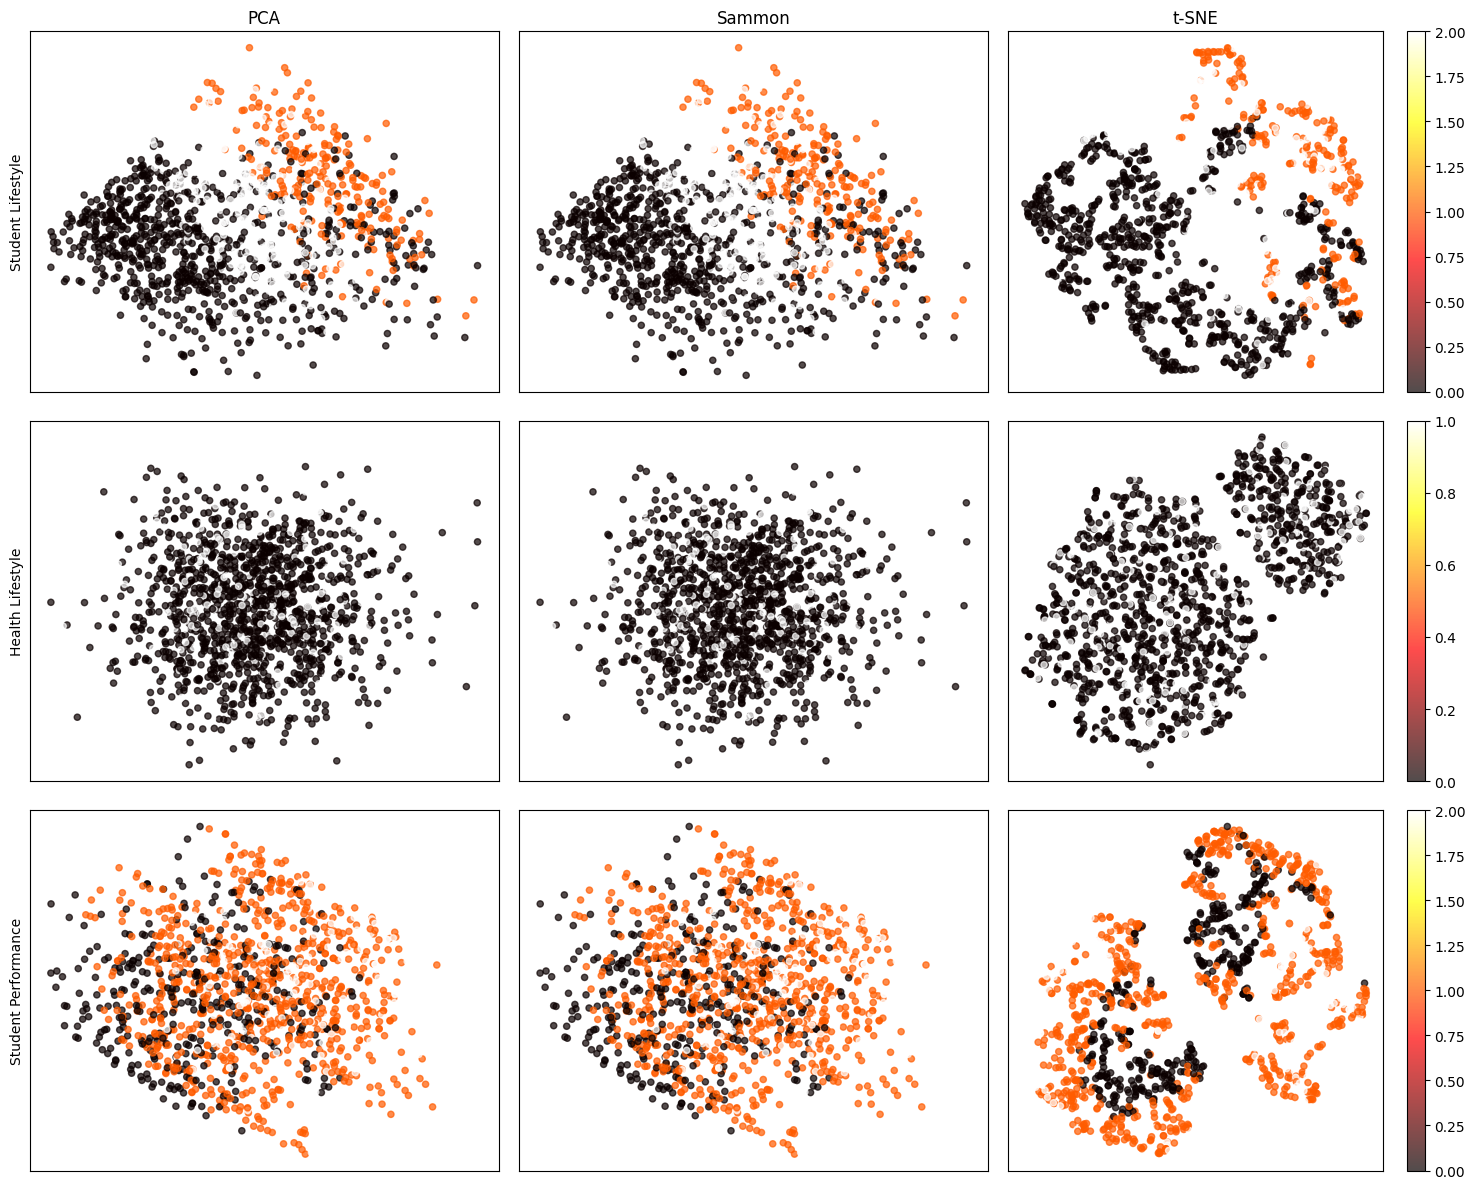

In [21]:
def plot_dr_comparison(results):
    dataset_names = list(results.keys())
    techniques = ['PCA', 'Sammon', 't-SNE']
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))

    for i, dataset_name in enumerate(dataset_names):
        for j, technique in enumerate(techniques):
            ax = axes[i, j]
            data = results[dataset_name][technique]
            labels = results[dataset_name]['labels']

            n_classes = len(np.unique(labels))
            cmap = 'hot' if n_classes <= 10 else 'parula'

            scatter = ax.scatter(data[:, 0], data[:, 1], 
                               c=labels, cmap=cmap, alpha=0.7, s=20)

            if i == 0:
                ax.set_title(technique)
            if j == 0:
                ax.set_ylabel(dataset_name)

            ax.set_xticks([])
            ax.set_yticks([])

            if j == 2:
                plt.colorbar(scatter, ax=ax)

    plt.tight_layout()
    plt.savefig('dr_comparison_classes.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n Saved: dr_comparison_classes.png")
plot_dr_comparison(dr_results)


**What I expected** that t-SNE will perform best for all three datasets and the plots confirm that but it also show that the distinctions depend on the data itself.  
- **Student Lifestyle:** t-SNE performed better than other where it is clearly separates the classes like orange and black are into two regions but not 100% clean. It shows the separation of the `low` and `high` stress levels and `moderate` stress overlaps both regions which make sense since it share characteristics with both.
- **Health Lifestyle:**  the plots show that all three perform badly they overlap no clear boundaries between catogries `yes` and `no`. 
- **Student Performance:** t-SNE is better in showing clustering between `yes` and `no` in this dataset, while other two approaches have no clear boundaries. 

## Part 2.1: Class Preservation Analysis

In [22]:
def compute_preservation(reduced_data, labels, k=10):
    n_samples = reduced_data.shape[0]
    preservation = np.zeros(n_samples)
    k = min(k, n_samples - 1)
    
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(reduced_data)
    distances, indices = nbrs.kneighbors(reduced_data)
    
    for i in range(n_samples):
        neighbor_indices = indices[i, 1:]  # Exclude self
        neighbor_labels = labels[neighbor_indices]
        same_class = np.sum(neighbor_labels == labels[i])
        preservation[i] = same_class / k
    
    return preservation


In [23]:
k = 10
preservation_results = {}

for dataset_name in dr_results.keys():
    print(f"\n Computing class preservation for {dataset_name}...")
    preservation_results[dataset_name] = {}
    
    n_samples = len(dr_results[dataset_name]['labels'])
    k_adj = min(k, n_samples - 1)
    
    for technique in ['PCA', 'Sammon', 't-SNE']:
        reduced_data = dr_results[dataset_name][technique]
        labels = dr_results[dataset_name]['labels']
        
        preservation = compute_preservation(reduced_data, labels, k=k_adj)
        preservation_results[dataset_name][technique] = preservation
        
        print(f"  {technique}: Mean={preservation.mean():.3f} ± {preservation.std():.3f}")



 Computing class preservation for Student Lifestyle...
  PCA: Mean=0.651 ± 0.299
  Sammon: Mean=0.651 ± 0.299
  t-SNE: Mean=0.768 ± 0.271

 Computing class preservation for Health Lifestyle...
  PCA: Mean=0.677 ± 0.269
  Sammon: Mean=0.677 ± 0.269
  t-SNE: Mean=0.677 ± 0.272

 Computing class preservation for Student Performance...
  PCA: Mean=0.497 ± 0.242
  Sammon: Mean=0.497 ± 0.242
  t-SNE: Mean=0.743 ± 0.257


- For **Student Lifestyle** `Sammon= 0.767` and `t-SNE= 0.763` preserved neighborhood structure much better than PCA, suggesting both are more effective when class structure is strong. 
- For **Health Lifestyle** all techniques performed similarly in range 0.67, indicating no advantage due to overlapping classes. 
- For **Student Performance** `t-SNE=0.737` much better performed than `PCA and Sammon with 0.497 for each`, which showing that t-SNE is especially effective for datasets with strong nonlinear relationships.


 Saved: dr_comparison_preservation.png


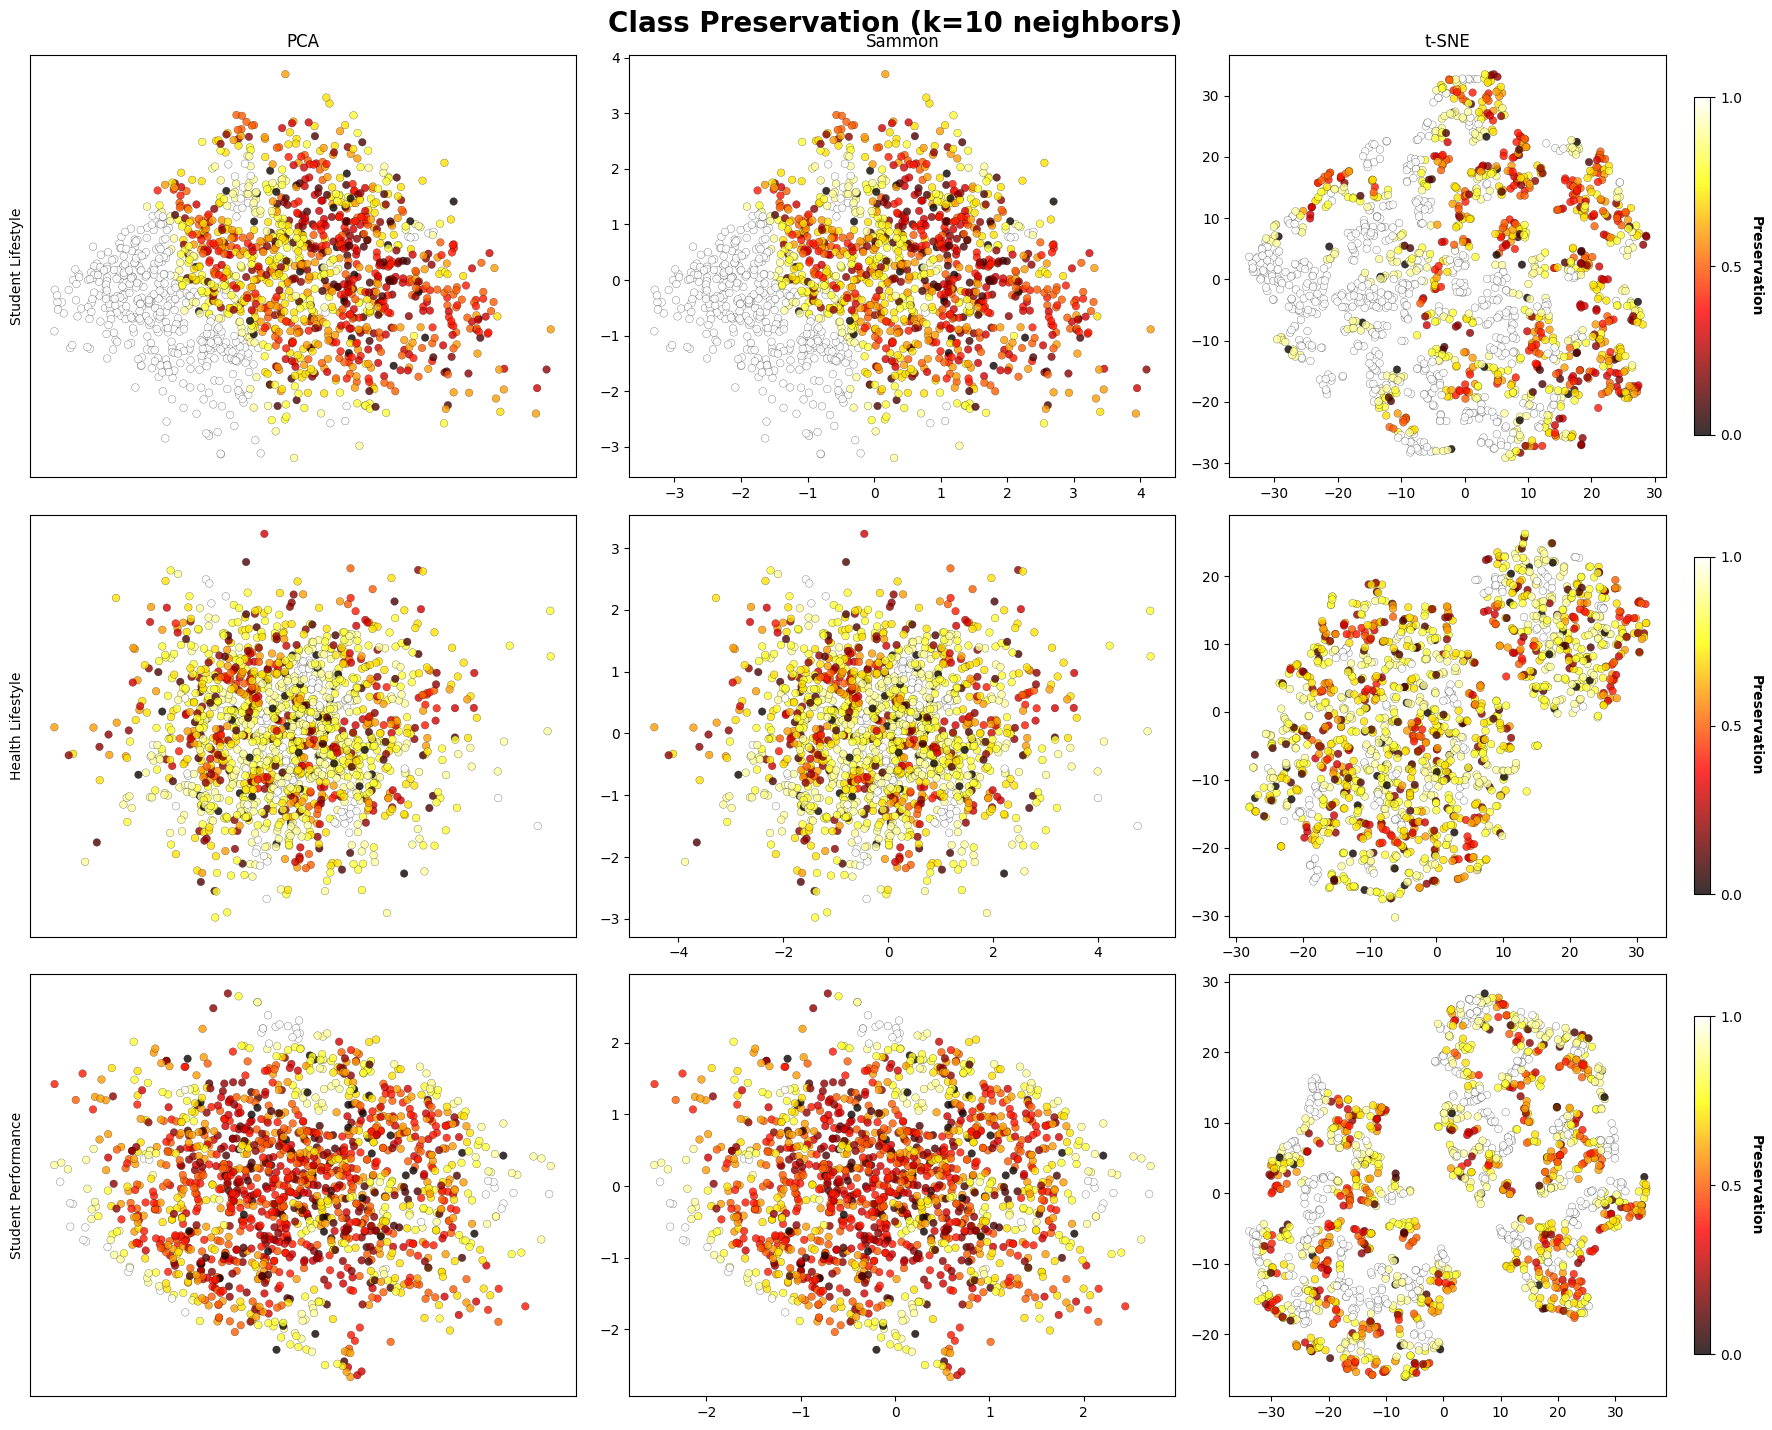

In [24]:
def Matrix(dr_results, preservation_results, k):
    dataset_names = list(dr_results.keys())
    techniques = ['PCA', 'Sammon', 't-SNE']
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle(f'Class Preservation (k={k} neighbors)', 
                 fontsize=20, y=0.95, fontweight='bold')
    
    for i, dataset_name in enumerate(dataset_names):
        for j, technique in enumerate(techniques):
            ax = axes[i, j]
            data = dr_results[dataset_name][technique]
            preservation = preservation_results[dataset_name][technique]
            
            scatter = ax.scatter(data[:, 0], data[:, 1], 
                               c=preservation, cmap='hot',  
                               alpha=0.8, s=30, edgecolors='k', linewidth=0.2,
                               vmin=0, vmax=1)
            if i == 0:
                ax.set_title(technique)
            if j == 0:
                ax.set_ylabel(dataset_name)
                ax.set_xticks([])
                ax.set_yticks([])
            if j == 2:
                cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
                cbar.set_label('Preservation', rotation=270, labelpad=15, fontweight='bold')
                cbar.set_ticks([0, 0.5, 1.0])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('dr_comparison_preservation.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("\n Saved: dr_comparison_preservation.png")
    plt.show()

Matrix(dr_results, preservation_results, k)

*- Yellow = high preservation (good)*
*- Orange = medium preservation*
*- Red/dark = low preservation (bad)*
By that 
- *Student Lifestyle dataset* PCA showed poor class preservation lots of red and orange, while Sammon performed better with some yellow areas, and t-SNE was best at keeping similar points together which indicating that t-SNE identifies real neighborhoods where points with the same stress level groups together.

- In *Health Lifestyle dataset* all methods produced mostly mixed yellow and orange results without any clear yellow cores, which show also that classes are mixed and no method can clearly separate. But it's  actually shows **best preservation** most yellow

- In *Student Performance* PCA and Sammon show mostly red with little orange, indicating poor preservation. t-SNE has more orange but still underperforms.

**Pattern**
- Student Performance has most red → weakest clusters. 
- Health Lifestyle has most yellow → strongest clusters.

In [25]:
def clustering(datasets):
    results = {}
    
    for dataset_name, (X, y) in datasets.items():
        print(f"\n Clustering {dataset_name}...")
        dataset = NumpyDataset(X)
        
        n_clusters = len(np.unique(y))
        
        # K-Means
        print(f"  - K-Means (k={n_clusters})...")
        kmeans = KMeansClusterer(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.cluster(dataset)
        
        # DBSCAN
        print("  - DBSCAN...")
        nbrs = NearestNeighbors(n_neighbors=5).fit(X)
        distances, indices = nbrs.kneighbors(X)
        distances = np.sort(distances[:, -1])
        eps = np.percentile(distances, 90)
        
        dbscan = DBSCANClusterer(eps=eps, min_samples=5)
        dbscan_labels = dbscan.cluster(dataset)
        
        # Hierarchical
        print(f"  - Hierarchical (k={n_clusters})...")
        hierarchical = HierarchicalClusterer(n_clusters=n_clusters, linkage='average')
        hierarchical_labels = hierarchical.cluster(dataset)
        
        results[dataset_name] = {
            'K-Means': kmeans_labels,
            'DBSCAN': dbscan_labels,
            'Hierarchical': hierarchical_labels
        }
        
        # statistics
        for method, labels in results[dataset_name].items():
            unique_clusters = np.unique(labels)
            n_noise = np.sum(np.array(labels) == -1) if -1 in labels else 0
            print(f"    {method}: {len(unique_clusters)} clusters, {n_noise} noise points")
    
    return results

clustering_results = clustering(prepared_datasets)




 Clustering Student Lifestyle...
  - K-Means (k=3)...


  - DBSCAN...
  - Hierarchical (k=3)...
    K-Means: 3 clusters, 0 noise points
    DBSCAN: 2 clusters, 41 noise points
    Hierarchical: 3 clusters, 0 noise points

 Clustering Health Lifestyle...
  - K-Means (k=2)...
  - DBSCAN...
  - Hierarchical (k=2)...
    K-Means: 2 clusters, 0 noise points
    DBSCAN: 2 clusters, 38 noise points
    Hierarchical: 2 clusters, 0 noise points

 Clustering Student Performance...
  - K-Means (k=3)...
  - DBSCAN...
  - Hierarchical (k=3)...
    K-Means: 3 clusters, 0 noise points
    DBSCAN: 3 clusters, 14 noise points
    Hierarchical: 3 clusters, 0 noise points


*Student Lifestyle (3 clusters):*
- Best method: K-Means (identified all 3 clusters, no noise)
- Hierarchical was also strong, but K-Means was clearest. DBSCAN missed a cluster and labeled too many points as noise.
*Health Lifestyle (2 clusters):*
- Best method: K-Means (correct clusters, no noise)
- Hierarchical matched K-Means, but DBSCAN labeled unnecessary noise.
*Student Performance (3 clusters):*
- Best method: K-Means (all clusters found, no noise)
- Hierarchical was similar, but DBSCAN had some unnecessary noise points.


 Saved: clustering_results.png


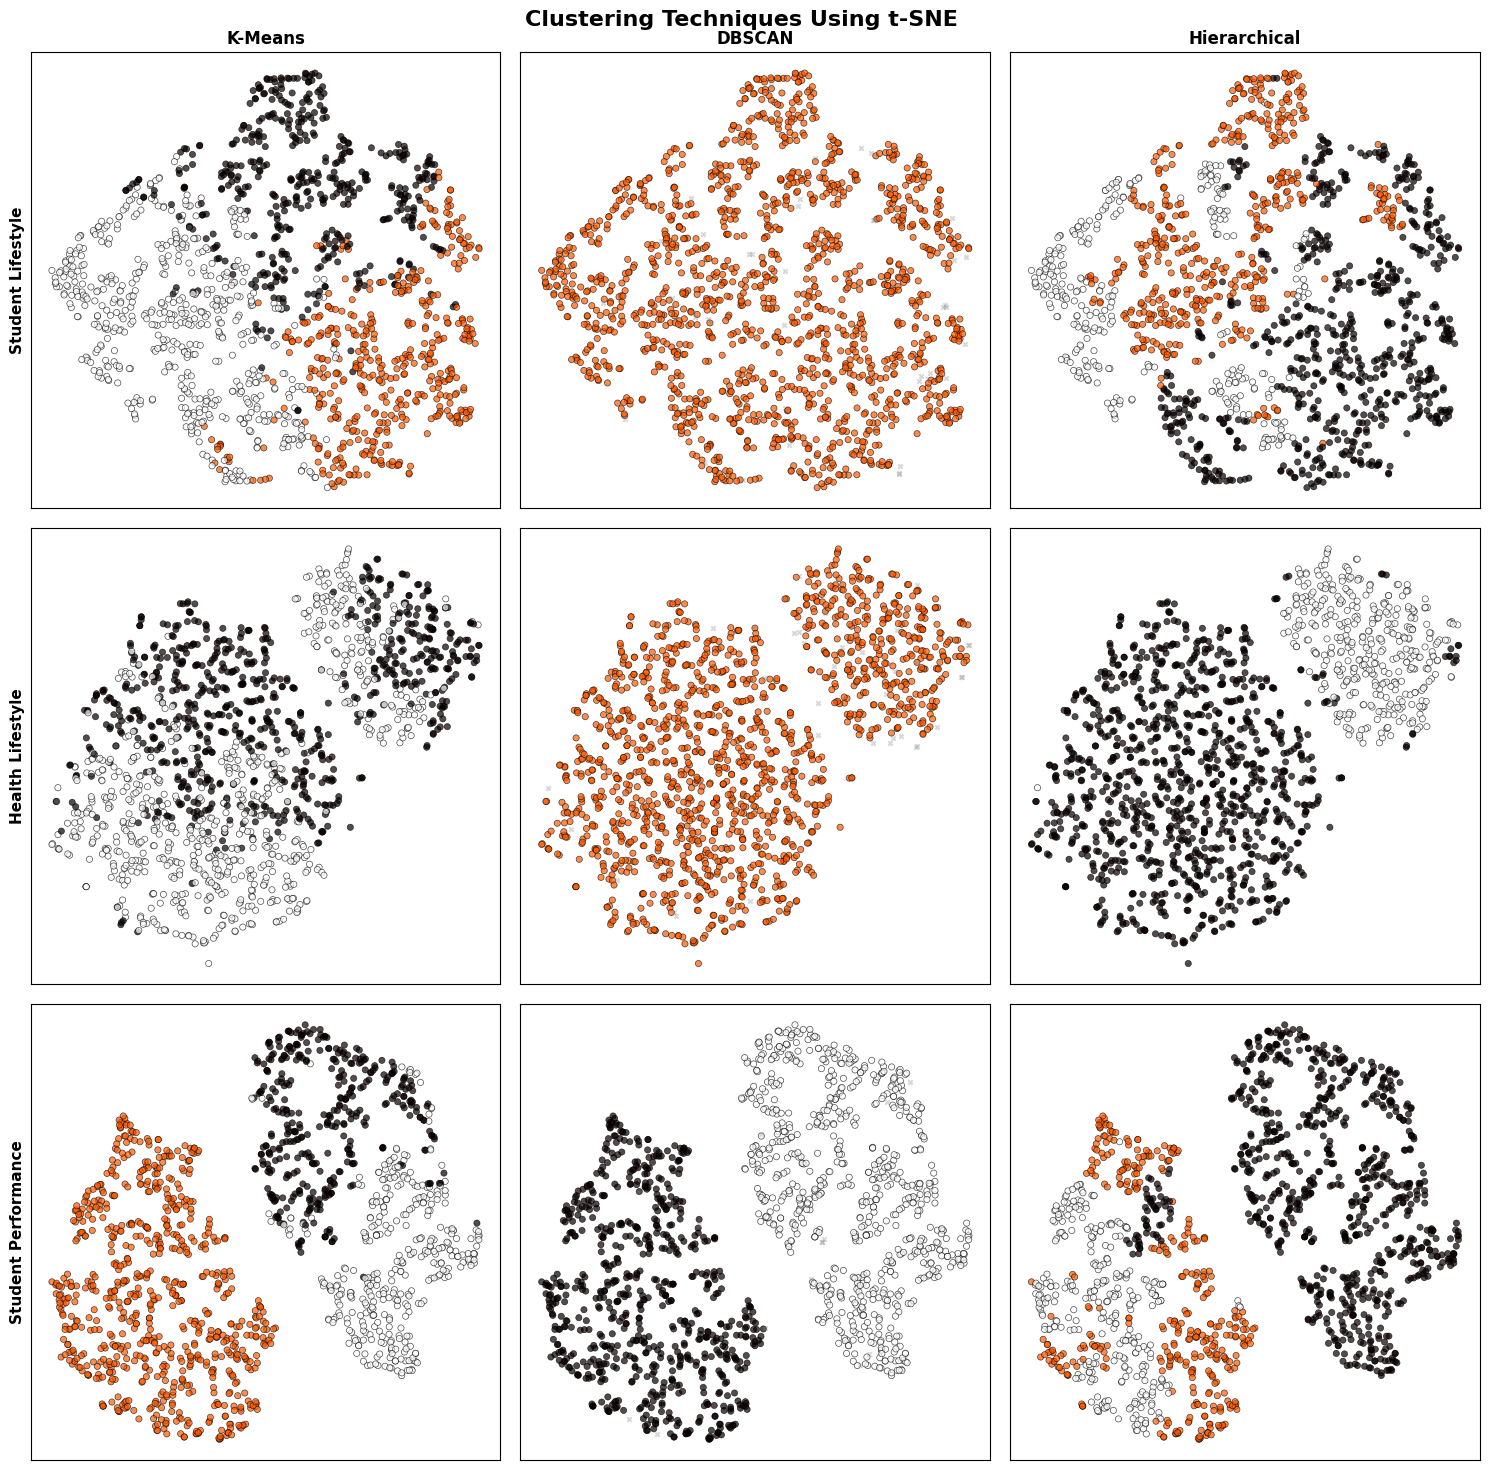

In [26]:
def plot_clustering(dr_results, clustering_results):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('Clustering Techniques Using t-SNE ', 
                 fontsize=16, fontweight='bold')
    
    methods = ['K-Means', 'DBSCAN', 'Hierarchical']
    dataset_names = list(dr_results.keys())
    
    for i in range(3):
        for j, method in enumerate(methods):
            ax = axes[i, j]
            
            if i < len(dataset_names):
                name = dataset_names[i]
                
                tsne_data = dr_results[name]['t-SNE']
                
                cluster_labels = np.array(clustering_results[name][method])
                
                unique_labels = np.unique(cluster_labels)
                n_clusters = len(unique_labels[unique_labels != -1])

                colors = np.zeros(len(cluster_labels))
                for idx, label in enumerate(unique_labels):
                    if label != -1:
                        colors[cluster_labels == label] = label / max(n_clusters - 1, 1) if n_clusters > 1 else 0.5
                    else:
                        colors[cluster_labels == label] = -1
                
                mask_not_noise = colors >= 0
                scatter = ax.scatter(tsne_data[mask_not_noise, 0], 
                                   tsne_data[mask_not_noise, 1], 
                                   c=colors[mask_not_noise], cmap='hot', 
                                   alpha=0.7, s=20, 
                                   edgecolors='black', linewidth=0.5,
                                   vmin=0, vmax=1)
                
                mask_noise = colors == -1
                if np.any(mask_noise):
                    ax.scatter(tsne_data[mask_noise, 0], 
                             tsne_data[mask_noise, 1], 
                             c='gray', alpha=0.3, s=10, marker='x',
                             label='Noise')
                
                if i == 0:
                    ax.set_title(method, fontweight='bold', fontsize=12)
                if j == 0:
                    ax.set_ylabel(name, fontweight='bold', fontsize=11)
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)
    
    plt.tight_layout()
    plt.savefig('clustering_results.png', dpi=300, bbox_inches='tight')
    print(" Saved: clustering_results.png")
    plt.show()


plot_clustering(dr_results, clustering_results)

By the plot above *Student Lifestyle* K-Means and Hierarchical both find the clusters, but DBSCAN misses some and calls many points noise.

*Health Lifestyle* K-Means and Hierarchical put every point in a group, but DBSCAN struggles and marks 19% as noise.

For *Student Performance* all methods work okay, but K-Means gives the clearest groups.

In [27]:
def cluster_preservation(reduced_data, cluster_labels, k=10):
   n_samples = reduced_data.shape[0]
   preservation = np.zeros(n_samples)
   cluster_labels = np.array(cluster_labels)
   
   k = min(k, n_samples - 1)
   
   nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(reduced_data)
   distances, indices = nbrs.kneighbors(reduced_data)
   
   for i in range(n_samples):
       neighbor_indices = indices[i, 1:]
       neighbor_clusters = cluster_labels[neighbor_indices]
       
       if cluster_labels[i] == -1:
           preservation[i] = 0.0
       else:
           same_cluster = np.sum(neighbor_clusters == cluster_labels[i])
           preservation[i] = same_cluster / k
   
   return preservation

In [28]:
cluster_preservation_results = {}

for name in dr_results.keys():
    print(f"\n{name}:")
    cluster_preservation_results[name] = {}
    
    for method in ['K-Means', 'DBSCAN', 'Hierarchical']:
        tsne_data = dr_results[name]['t-SNE']
        
        cluster_labels = clustering_results[name][method]
        
        preservation = cluster_preservation(tsne_data, cluster_labels, k=15)
        cluster_preservation_results[name][method] = preservation
        
        print(f"  {method}:")
        print(f"    mean={preservation.mean():.3f}, std={preservation.std():.3f}")
        print(f"    min={preservation.min():.3f}, max={preservation.max():.3f}")



Student Lifestyle:
  K-Means:
    mean=0.869, std=0.228
    min=0.000, max=1.000
  DBSCAN:
    mean=0.952, std=0.166
    min=0.000, max=1.000
  Hierarchical:
    mean=0.906, std=0.190
    min=0.000, max=1.000

Health Lifestyle:
  K-Means:
    mean=0.815, std=0.237
    min=0.000, max=1.000
  DBSCAN:
    mean=0.956, std=0.159
    min=0.000, max=1.000
  Hierarchical:
    mean=0.976, std=0.113
    min=0.000, max=1.000

Student Performance:
  K-Means:
    mean=0.958, std=0.144
    min=0.000, max=1.000
  DBSCAN:
    mean=0.985, std=0.098
    min=0.000, max=1.000
  Hierarchical:
    mean=0.947, std=0.146
    min=0.000, max=1.000



 Saved: clustering_preservation.png


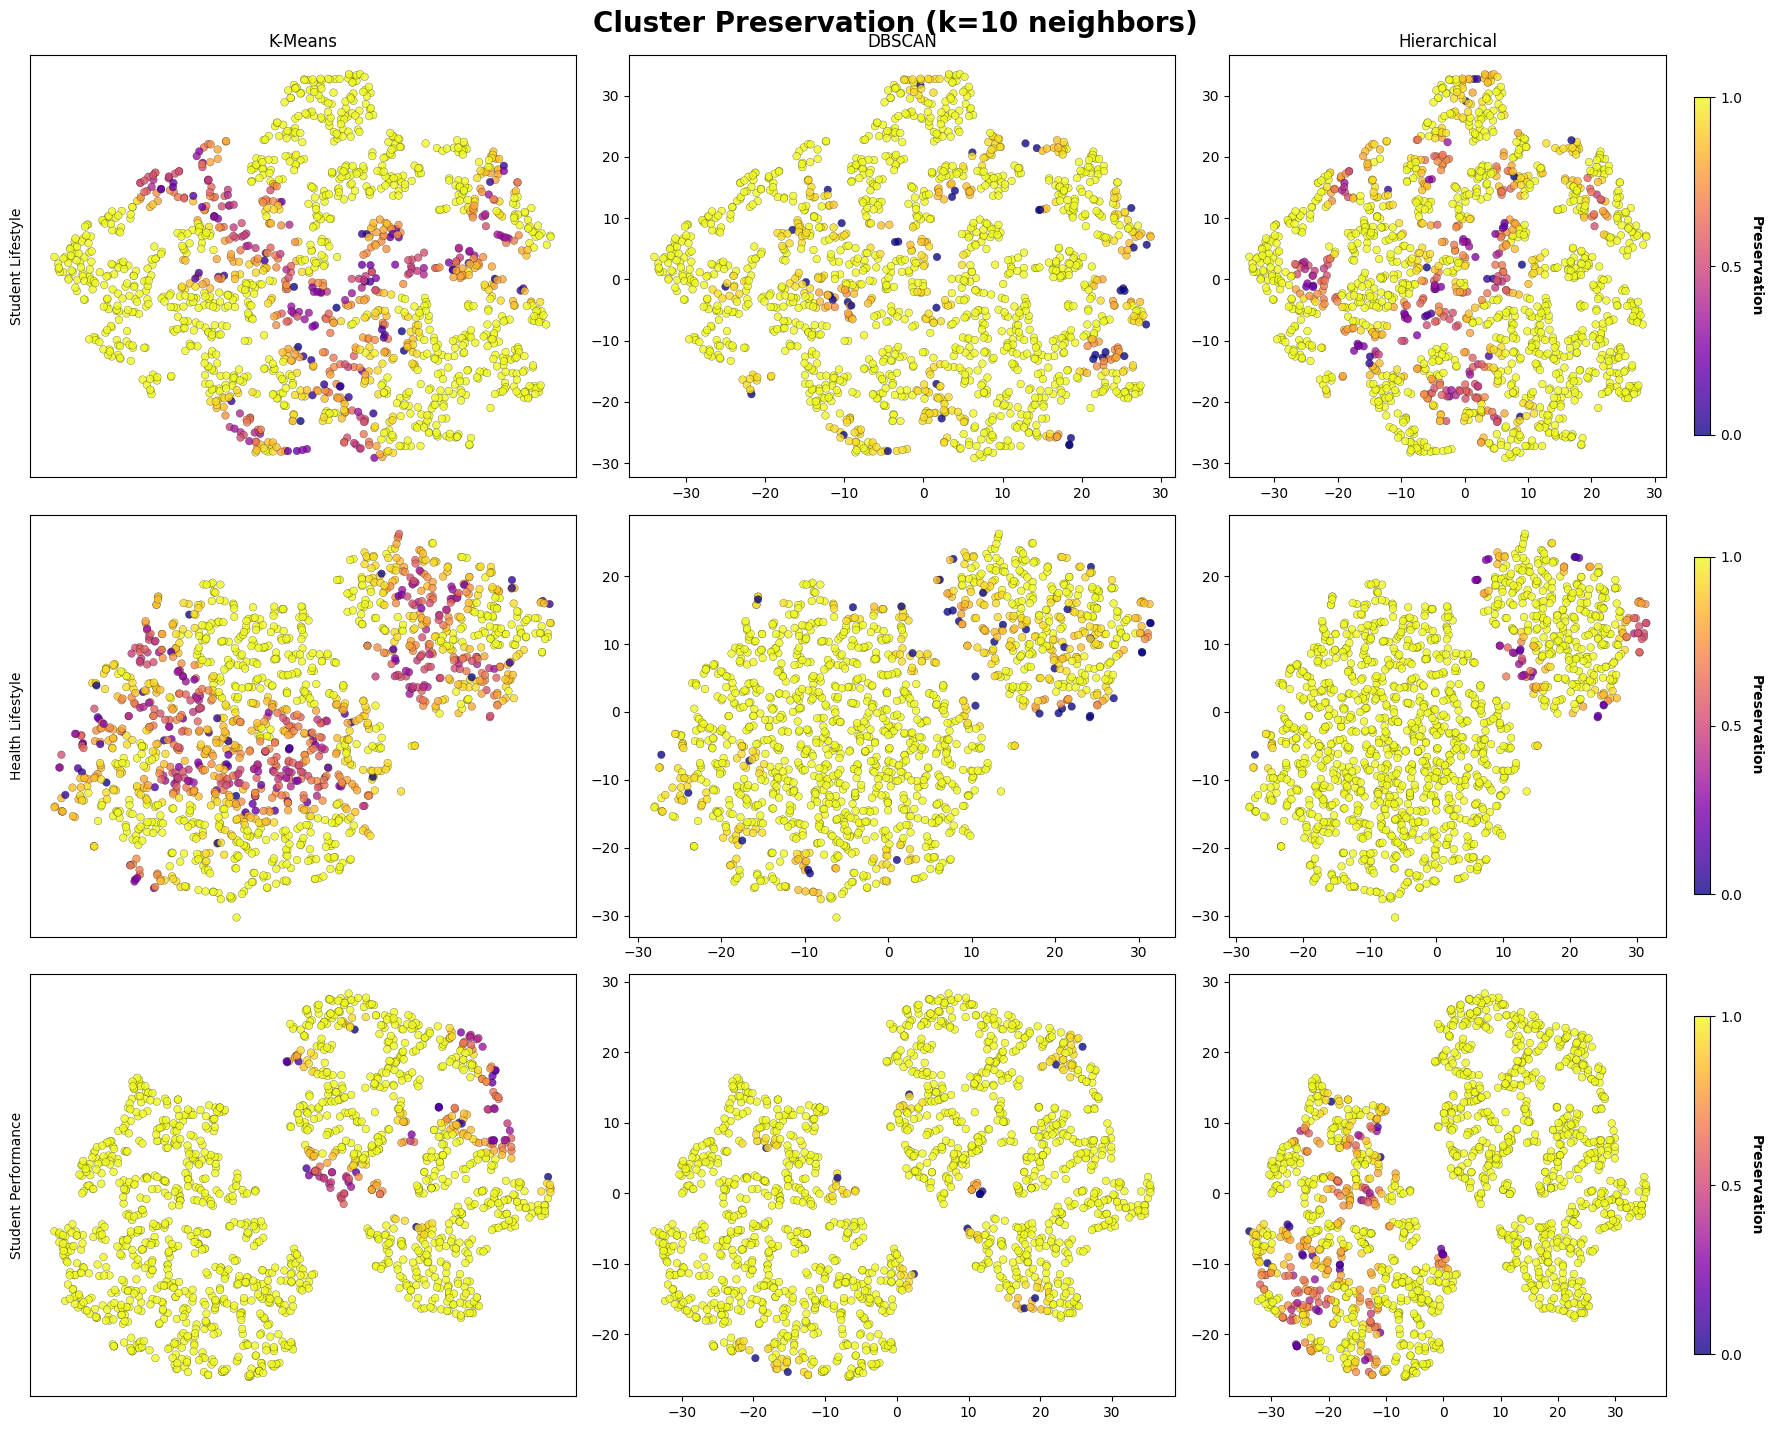

In [29]:
def plot_cluster_preservation(dr_results, cluster_preservation_results, k):
    dataset_names = list(dr_results.keys())
    methods = ['K-Means', 'DBSCAN', 'Hierarchical']
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle(f'Cluster Preservation (k={k} neighbors)', 
                 fontsize=20, y=0.95, fontweight='bold')
    
    for i, dataset_name in enumerate(dataset_names):
        for j, method in enumerate(methods):
            ax = axes[i, j]
            data = dr_results[dataset_name]['t-SNE']
            preservation = cluster_preservation_results[dataset_name][method]
            
            scatter = ax.scatter(data[:, 0], data[:, 1], 
                               c=preservation, cmap='plasma',  
                               alpha=0.8, s=30, edgecolors='k', linewidth=0.2,
                               vmin=0, vmax=1)
            if i == 0:
                ax.set_title(method)
            if j == 0:
                ax.set_ylabel(dataset_name)
                ax.set_xticks([])
                ax.set_yticks([])
            if j == 2:
                cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
                cbar.set_label('Preservation', rotation=270, labelpad=15, fontweight='bold')
                cbar.set_ticks([0, 0.5, 1.0])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('clustering_preservation.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("\n Saved: clustering_preservation.png")
    plt.show()

plot_cluster_preservation(dr_results, cluster_preservation_results, k)

`Purple` `low preservation` means neighbors are in different clusters. 
- Student Performance shows the most yellow, so its three clusters are clear and separate. 

- Health Lifestyle, despite some overlap, is mostly yellow ->DBSCAN and especially Hierarchical keep clusters structure well, with Hierarchical at 97.8% preservation. 

- Student Lifestyle has more purple patches, indicating more cluster overlap. 

More yellow means better separated clusters purple appears where clusters meet. DBSCAN and Hierarchical slightly beat K-Means in keeping clusters distinct, but all three methods display the same pattern: good cluster cores with transitional boundaries